# Домашнее задание №2 (HW02)

## Загрузка данных и первичный осмотр

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

D:\Programs\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('S02-hw-dataset.csv')

In [3]:
# Первые 5 строк датасета
df.head()

,user_id,age,country,purchases,revenue
0,1,25.0,FR,7,749
1,2,24.0,RU,5,1115
2,3,52.0,FR,7,399
3,4,31.0,RU,6,654
4,5,NaN,DE,6,1296


In [4]:
# Информация о столбцах и типах данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB


In [5]:
# Базовые описательные статистики
df.describe()

,user_id,age,purchases,revenue
count,41.000000,39.000000,41.000000,41.000000
mean,20.243902,36.512821,4.829268,820.048780
std,11.659289,18.304259,2.710189,613.127269
min,1.000000,5.000000,-1.000000,0.000000
25%,10.000000,24.000000,3.000000,432.000000
50%,20.000000,33.000000,5.000000,693.000000
75%,30.000000,45.500000,7.000000,1115.000000
max,40.000000,120.000000,11.000000,2475.000000


## Пропуски, дубликаты и базовый контроль качества

In [6]:
# Доля пропусков в каждом столбце
missing_percent = df.isna().mean() * 100
print("Доля пропусков (%):")
print(missing_percent.round(2))

Доля пропусков (%):
user_id      0.00
age          4.88
country      0.00
purchases    0.00
revenue      0.00
dtype: float64


In [7]:
# Проверка дубликатов
duplicates = df.duplicated().sum()
print(f"Количество полных дубликатов: {duplicates}")

Количество полных дубликатов: 1


In [8]:
# Поиск подозрительных значений
suspicious_cases = {
    'negative_age': df[df['age'] < 0],
    'age_over_100': df[df['age'] > 100],
    'negative_purchases': df[df['purchases'] < 0],
    'negative_revenue': df[df['revenue'] < 0],
    'zero_purchases_nonzero_revenue': df[(df['purchases'] == 0) & (df['revenue'] > 0)]
}

for case_name, cases in suspicious_cases.items():
    if not cases.empty:
        print(f"\nПодозрительные случаи: {case_name}")
        display(cases.head())


Подозрительные случаи: age_over_100


,user_id,age,country,purchases,revenue
5,6,120.0,FR,-1,785



Подозрительные случаи: negative_purchases


,user_id,age,country,purchases,revenue
5,6,120.0,FR,-1,785


В ходе анализа выявлены следующие проблемы:
1. **Пропуски в возрасте**: 4.88% записей не содержат данных о возрасте пользователей
2. **Критичные аномалии**:
   - Возраст 120 лет (максимально допустимый возраст для анализа - 100 лет)
   - Отрицательное количество покупок (-1) у пользователя из Франции
3. **Дубликаты**: обнаружена 1 полностью повторяющаяся строка

Все аномалии сосредоточены в одной записи (user_id=6).

## Базовый EDA: группировки и агрегаты

In [9]:
# Частоты категориальной переменной (страны)
country_freq = df['country'].value_counts()
print("Топ-5 стран по количеству пользователей:")
print(country_freq.head())

Топ-5 стран по количеству пользователей:
country
RU    13
FR    12
US     8
DE     6
CN     2
Name: count, dtype: int64


In [10]:
# Группировка по странам с агрегатами
country_stats = df.groupby('country').agg(
    avg_age=('age', 'mean'),
    total_purchases=('purchases', 'sum'),
    avg_revenue=('revenue', 'mean')
).sort_values('total_purchases', ascending=False)

print("\nСтатистика по странам (топ-5 по общим покупкам):")
display(country_stats.head())


Статистика по странам (топ-5 по общим покупкам):


,avg_age,total_purchases,avg_revenue
country,,,
RU,30.076923,62,790.076923
FR,46.250000,51,675.916667
DE,34.600000,39,1445.500000
US,36.714286,37,557.375000
CN,24.000000,9,1054.000000


In [11]:
# Создание возрастных групп
bins = [0, 18, 25, 35, 45, 60, 100]
labels = ['0-18', '19-25', '26-35', '36-45', '46-60', '60+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Группировка по возрастным категориям
age_group_stats = df.groupby('age_group', observed=True).agg(
    users_count=('user_id', 'count'),
    avg_purchases=('purchases', 'mean'),
    avg_revenue=('revenue', 'mean')
).sort_values('avg_revenue', ascending=False)

print("\nСтатистика по возрастным группам:")
display(age_group_stats)


Статистика по возрастным группам:


,users_count,avg_purchases,avg_revenue
age_group,,,
0-18,1,8.0,1488.000000
36-45,7,5.0,1042.857143
26-35,10,5.3,1009.600000
19-25,10,4.7,617.100000
46-60,10,4.1,585.600000


**Основные наблюдения:**
1. **Географическое распределение**:
   - Лидеры по числу пользователей: Россия (13) и Франция (12)
   - Наибольшая средняя выручка: у пользователей из Германии (1445.5 USD) и Китая (1054 USD), несмотря на небольшую долю в выборке
   - Россия генерирует наибольшее общее количество покупок (62), но средняя выручка ниже среднего (790 USD)

2. **Возрастные особенности**:
   - Самые прибыльные группы: 0-18 лет (1488 USD, но в категории 1 запись) и 36-45 лет (1043 USD)
   - Пользователи 19-25 лет совершают больше покупок (4.7 в среднем), чем группа 46-60 лет (4.1), но их средняя выручка ниже (617 vs 586 USD)
   - В данных отсутствуют пользователи старше 60 лет

## Визуализация данных

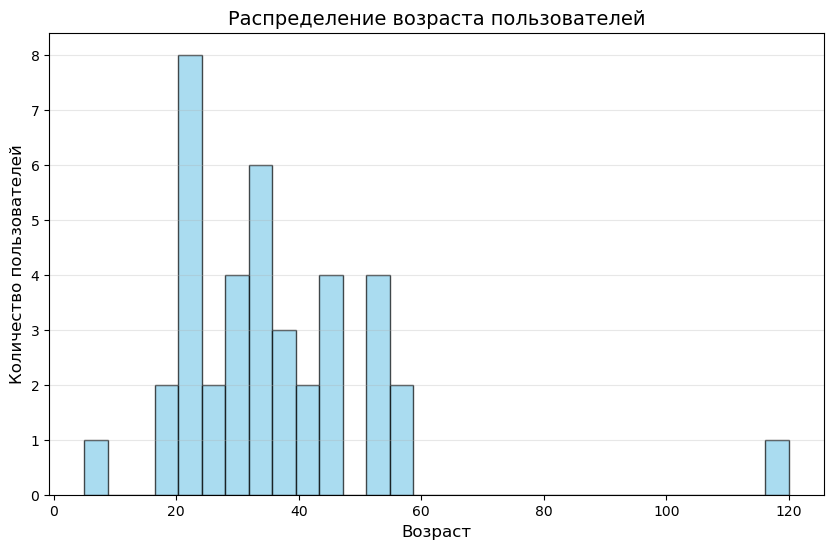

In [12]:
# Гистограмма распределения возраста
plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Распределение возраста пользователей', fontsize=14)
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.savefig('figures/age_histogram.png', bbox_inches='tight')
plt.show()

**Гистограмма распределения возраста пользователей**  
График показывает количество пользователей в разных возрастных группах. Основные пики - 20-24 года (8 пользователей) и 32-36 лет (6 пользователей). Обнаружена аномалия: 1 пользователь с возрастом 120 лет. Пользователи старше 60 лет отсутствуют.

**Выводы:**  
1. Целевая аудитория - молодые люди 20-40 лет.  
2. Запись с возрастом 120 лет требует удаления или исправления (ошибка данных).  
3. Низкая представленность возрастов 45+ указывает на узкую сегментацию продукта. 

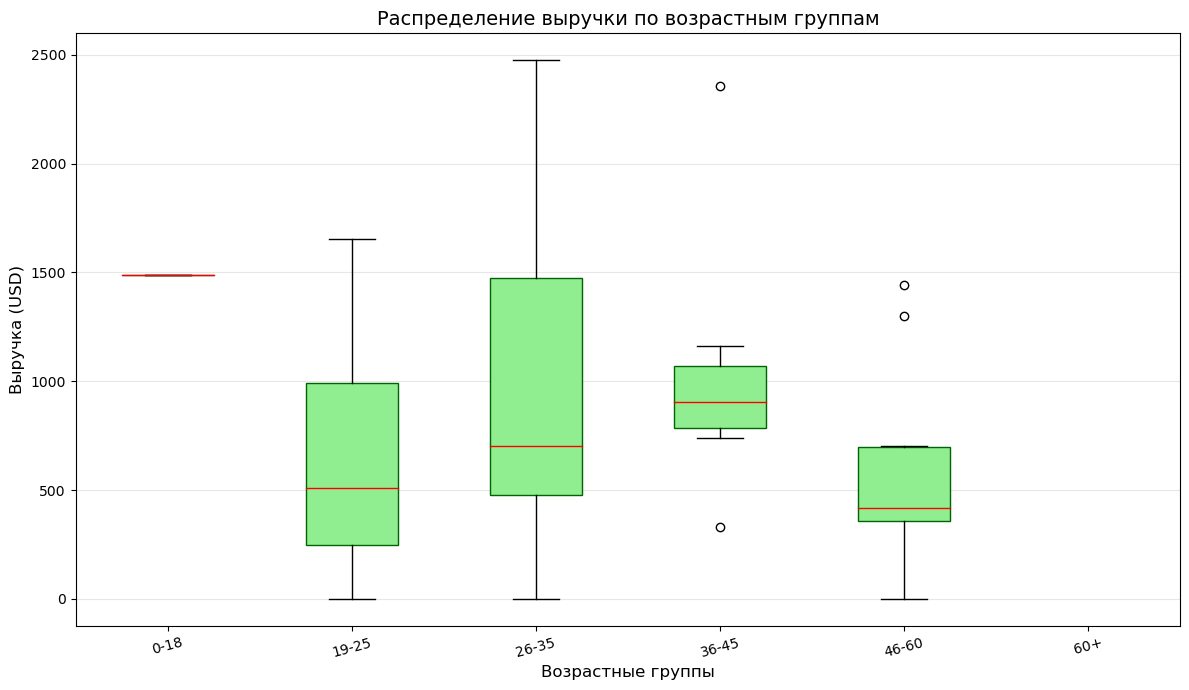

In [13]:
# Боксплот выручки по возрастным группам
plt.figure(figsize=(12, 7))
boxplot_data = [df[df['age_group'] == group]['revenue'] for group in labels]
plt.boxplot(boxplot_data, labels=labels, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='darkgreen'),
            medianprops=dict(color='red'))
plt.title('Распределение выручки по возрастным группам', fontsize=14)
plt.xlabel('Возрастные группы', fontsize=12)
plt.ylabel('Выручка (USD)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('figures/revenue_by_age_group.png', bbox_inches='tight', dpi=300)
plt.show()

**Боксплот распределения выручки по возрастным группам**  
График показывает медиану, межквартильный размах и выбросы выручки (USD) в каждой возрастной группе.  

**Ключевые наблюдения:**  
1. Группа 26-35 лет - лидирует по выручке (медиана ~700 USD), но с самым высоким разбросом (максимум ~2500 USD).  
2. Группа 0-18 лет - малая выборка (1 значение), не является репрезентативной в сравнении с другими.  
3. Группа 60+ - отсутствует (соответствует данным: 0 пользователей).  
4. Выбросы в группах 36-45 и 46-60 (точки выше верхней границы) указывают на отдельных клиентов с аномально высокой выручкой.  

**Выводы:**  
- Основной вклад в выручку дают пользователи 26-35 лет, но с нестабильным поведением.  
- Сегменты 36-45 и 46-60 лет содержат клиентов с аномальной выручкой (выбросы).  
- Клиенты в группе 60+ отсутствуют

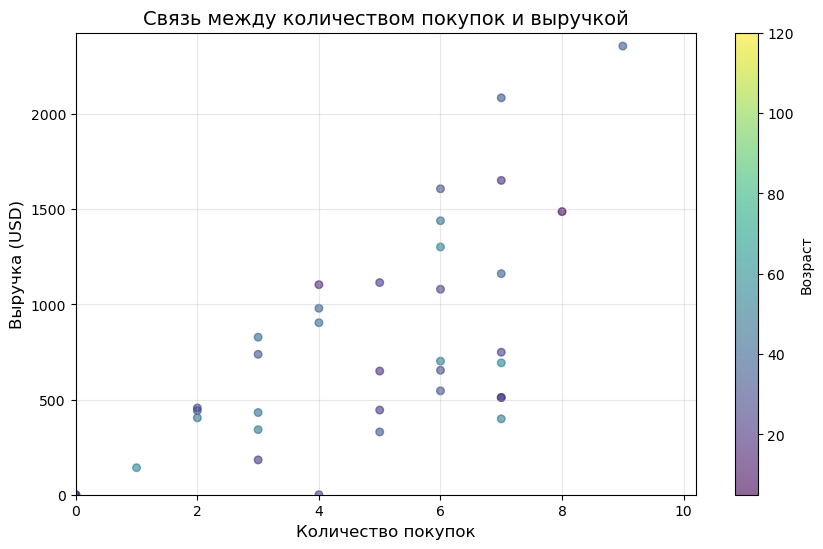

In [14]:
# Связь между количеством покупок и выручкой
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['purchases'], 
                      df['revenue'],
                      c=df['age'],
                      cmap='viridis',
                      alpha=0.6,
                      s=30)
plt.colorbar(scatter, label='Возраст')
plt.title('Связь между количеством покупок и выручкой', fontsize=14)
plt.xlabel('Количество покупок', fontsize=12)
plt.ylabel('Выручка (USD)', fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(0, df['purchases'].quantile(0.99))
plt.ylim(0, df['revenue'].quantile(0.99))
plt.savefig('figures/purchases_vs_revenue.png', bbox_inches='tight')
plt.show()

**Диаграмма рассеяния cвязи между количеством покупок и выручкой**  
График отображает зависимость выручки (USD) от количества покупок, с цветовой маркировкой по возрасту (фиолетовый — молодые, желтый — старшие).

**Ключевые наблюдения:**  
1. **Положительная корреляция**: с ростом количества покупок выручка увеличивается, но с сильным разбросом. Например:  
   - 8 покупок => выручка до 1500 USD,  
   - 9 покупок => аномально высокая выручка (~2300 USD, выброс).  
2. **Возрастные различия**:  
   - Молодые (фиолетовые): много покупок (6–8), но умеренная выручка (500-1000 USD).  
   - Старшие (желтые): меньше покупок (2–4), но высокая выручка (1000-1500 USD) - указывает на покупку дорогих товаров.  
3. **Аномалии**:  
   - Точка с 9 покупками и выручкой ~2300 USD (возможно, крутой клиент или ошибка данных),  
   - Отсутствие покупок (0) => нулевая выручка (логично).  

**Выводы:**  
- Выручка зависит не только от количества покупок, но и от ценовой категории товаров, которые попадают в эти покупки (старшие тратят больше за одну покупку).
- Группа молодых пользователей генерирует выручку через частые покупки, старших - через высокую стоимость заказов.  
- Аномалия с 9 покупками требует проверки (ошибка данных или эксклюзивный клиент).  